# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Decision Tree, and will then apply a Decision Tree classsifier on the MNIST hand written digits dataset that we already saw.


## Implementing Decision Tree From Scratch
We will implement a simple version of a Decision Tree from scratch. The tree will be able to handle **continuous input and output** (this should actually work also for binary input attributes).


In [1]:
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston


In [3]:
X, y = load_boston(return_X_y = True);
data = load_boston();
df = pd.DataFrame(data.data, columns = data.feature_names);
df.head()

C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housin

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
class Make_Node():
    def __init__(self, feature_idx = None, threshold = None, left = None, right = None, variance = None, value = None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.variance = variance
        self.value = value #For leaf node

class RegressionTree():
    def __init__(self, max_depth, min_split):
        self.root = None
        self.min_split = min_split
        self.max_depth = max_depth


    def split(self, df, feature_idx, threshold):
        left_child = np.array([sample for sample in df if sample[feature_idx] <= threshold])
        right_child = np.array([sample for sample in df if sample[feature_idx] > threshold])
        return left_child, right_child

    def train_squared_error(self, y, y_left, y_right):

        weight_left = len(y_left) / len(y)
        weight_right = len(y_right)/ len(y)
        variance = weight_left * np.var(y_left) + weight_right * np.var(y_right)

        #code says to subtract the parents error by the error fo the children. Not sure why we aren't just returning the variance of the children.
        return variance 



    def get_leaf(self, y):
        return np.mean(y)

    def best_feature(self, df, n_samples, n_features):
        best_split_dict = {}
        max_reduction = np.inf #Change variable to max_trained_squared_error?

        for feat_idx in range(n_features):
            feat_vals = df[:, feat_idx]
            threshold_options = np.unique(feat_vals)

            for threshold in threshold_options:
                left_child, right_child = self.split(df, feat_idx, threshold)
            
                if len(left_child) > 0 and len(right_child) > 0:
                    y, left_y, right_y = df[:, -1], left_child[:, -1], right_child[:, -1]

                    trained_squared_error = self.train_squared_error(y, left_y, right_y)

                    if trained_squared_error < max_reduction: #We want minimum variance. (If the trained_error function were to subtract frm the variance of the parent, flip to greater than).
                            best_split_dict["feature_idx"] = feat_idx
                            best_split_dict["threshold"] = threshold
                            best_split_dict["left_child"] = left_child
                            best_split_dict["right_child"] = right_child
                            best_split_dict["variance"] = trained_squared_error
                            max_reduction = trained_squared_error
        
        return best_split_dict


    def fit(self, X, y):
        df = np.concatenate((X, y), axis =1)
        self.root = self.build_tree(df)



    def build_tree(self, df, level = 0):
        X, y = df[:, :-1], df[:,-1]
        n_samples, n_features = np.shape(X)
        best_split = {} #hold all features of the split in  dict.
        if n_samples>= self.min_split and level <=self.max_depth:    #a1) Find the best feature for our tree to split on, if we haven't reached past our required tree size.

            best_split = self.best_feature(df, n_samples, n_features)

            if best_split['variance'] > 0:                          #a2) Split the tree based off this best feature into left and right subtrees
                left_tree = self.build_tree(best_split['left_child'], level +1)
                right_tree = self.build_tree(best_split['right_child'], level+1)

                return Make_Node(best_split['feature_idx'], best_split['threshold'], left_tree, right_tree, best_split['variance']) #a3) Make current split into Parent Node
        
        leaf = self.get_leaf(y)                                      #b1) if tree size has already been reached, (or reduction = 0), then create and return a Leaf Node.

        return Make_Node(value = leaf)


  

    def print_tree(self, tree=None, indent=" ", columns = None, level = 0, child = 'root' ):
            ''' function to print the tree '''
            self.columns = columns
            level+= 1

            if not tree:
                tree = self.root

            if tree.value is not None: #If there is value, this means it is a leaf node: return the regression value in this leaf node.
                print(' '*level*3, child, ': ',np.round(tree.value, 4))

            else: #Perform Pre-order traversal-- Root, Left, Right, (leaf).
                if self.columns is None: #If no column names were given, just print by column idx
                    print(f'{child}: X_{str(tree.feature_idx)}, "<=", {tree.threshold}, "?", {tree.variance}')
                    
                else:
                    print(' '*level*3, f'{child}: X_{self.columns[tree.feature_idx]}, "<=", {tree.threshold}, "?", {np.round(tree.variance, 4)}')

                    # print(indent, " |%sleft: " % (indent))
                    self.print_tree(tree.left, indent + indent, self.columns, level, child = 'left')
                    # print(indent, " |%sright :" % (indent), end)
                    self.print_tree(tree.right, indent + indent, self.columns, level, child = 'right')


    def make_prediction(self, x, root):

        if root.value:
            return root.value
        
        if x[root.feature_idx] < root.threshold:
            return self.make_prediction(x, root.left)

        else:
            return self.make_prediction(x, root.right)



    def predict(self, X):
        ''' function to predict a single data point '''
        
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions


In [5]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [6]:
regressor = RegressionTree(min_split=2, max_depth=20)
regressor.fit(X_train, Y_train)


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
for min_leaf in [2,5,10,100]: #Not working for values of 1 -- Need to fix this. Also, what should max depth be?
      regressor = RegressionTree(min_split=min_leaf, max_depth=20)
      regressor.fit(X_train, Y_train)
      mse = mean_squared_error(Y_test, regressor.predict(X_test)) # mean square error over test set
      print("min_leaf:{0} --- oob mse: {1}".format(min_leaf, mse))



min_leaf:2 --- oob mse: 55.08662720588235
min_leaf:5 --- oob mse: 48.14092386982571
min_leaf:10 --- oob mse: 50.37255103040444
min_leaf:100 --- oob mse: 29.07709343474029


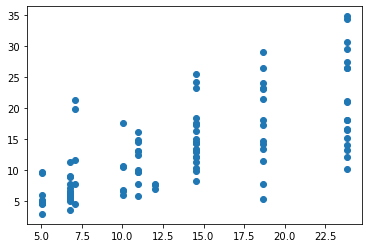

In [8]:
regressor = RegressionTree(min_split=100, max_depth=100)
regressor.fit(X_train, Y_train)
y_hat = regressor.predict(X_test)  # forest is the chosen model
plt.scatter(y_hat, Y_test)

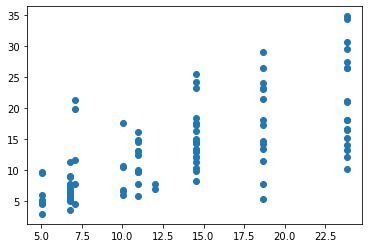

In [9]:
from sklearn.tree import DecisionTreeRegressor


tree = DecisionTreeRegressor(min_samples_split=100, max_depth=100) 
tree.fit(X_train, Y_train)
y_pred = tree.predict(X_test)   
plt.scatter(y_pred, Y_test)

We can see that we got quite similar results as sklearn

## Using Decision Tree for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
- Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.
  - You can use `sklearn.tree.DecisionTreeClassifier`
- Once you are satisfied with the model parameters, plot the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

We will optimize max_depth, min_samples_leaf,  and the criterion (gini or entropy), using GridSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV
from keras.datasets import mnist;
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay

Because of lack of resources for calculations, we will take only 10,000 samples

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = [x.flatten() for x in x_train]
x_test = [x.flatten() for x in x_test]

x_train=x_train[0:10000]
x_test=x_test[0:10000]

y_train=y_train[0:10000]
y_test=y_test[0:10000]

(The calculation takes about 5 minutes)

In [13]:
dt = DecisionTreeClassifier(random_state=42)
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 5, 10, 100],
    'min_samples_leaf': [5, 10, 20, 100],
    'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search.fit(x_train, y_train)


Fitting 4 folds for each of 32 candidates, totalling 128 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 100],
                         'min_samples_leaf': [5, 10, 20, 100]},
             scoring='accuracy', verbose=1)

In [14]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=100, min_samples_leaf=5,
                       random_state=42)

### MNIST-- Decision Tree

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       980
           1       0.91      0.95      0.93      1135
           2       0.78      0.79      0.78      1032
           3       0.75      0.79      0.77      1010
           4       0.80      0.77      0.78       982
           5       0.78      0.75      0.76       892
           6       0.84      0.82      0.83       958
           7       0.89      0.86      0.88      1028
           8       0.79      0.76      0.77       974
           9       0.78      0.79      0.78      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

accuracy:  0.8226
F1:  0.8202128687259215


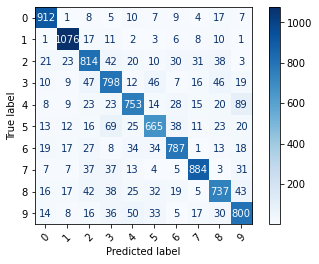

In [15]:
dt_best = grid_search.best_estimator_

dt_best.fit(x_train,y_train)

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

print(classification_report(y_test, dt_best.predict(x_test)))

confusion_matrix = confusion_matrix(y_test, dt_best.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)


from sklearn.metrics import f1_score, accuracy_score
print('accuracy: ', accuracy_score(y_test, dt_best.predict(x_test)))
print('F1: ', f1_score(y_test, dt_best.predict(x_test), average = 'macro'))

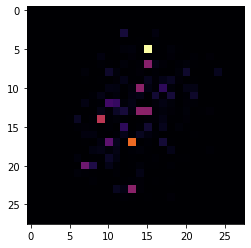

In [16]:
plt.imshow(dt_best.feature_importances_.reshape(28,28), cmap= 'inferno')


### MNIST-- Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier


dtt = RandomForestClassifier()
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 5, 10, 100],
    'min_samples_leaf': [5, 10, 20, 100],
    'criterion': ["gini", "entropy"]
}

grid_search = GridSearchCV(estimator=dtt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search.fit(x_train, y_train)

Fitting 4 folds for each of 32 candidates, totalling 128 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 100],
                         'min_samples_leaf': [5, 10, 20, 100]},
             scoring='accuracy', verbose=1)

In [18]:
grid_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=100, min_samples_leaf=5)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.93      0.92      1032
           3       0.93      0.93      0.93      1010
           4       0.93      0.93      0.93       982
           5       0.96      0.91      0.94       892
           6       0.94      0.96      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.93      0.92      0.92       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

accuracy:  0.9404
F1:  0.9398166591160223


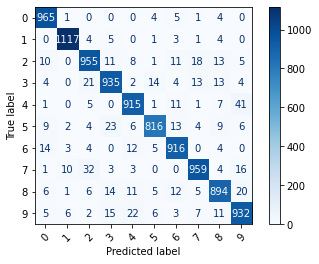

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

grid_search.best_estimator_
dtt_best = grid_search.best_estimator_

dtt_best.fit(x_train,y_train)

print(classification_report(y_test, dtt_best.predict(x_test)))

confusion_matrix = confusion_matrix(y_test, dtt_best.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

from sklearn.metrics import f1_score, accuracy_score
print('accuracy: ', accuracy_score(y_test, dtt_best.predict(x_test)))
print('F1: ', f1_score(y_test, dtt_best.predict(x_test), average = 'macro'))


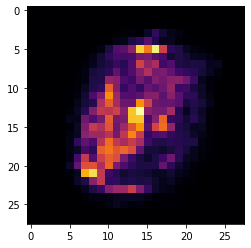

In [20]:
plt.imshow(dtt_best.feature_importances_.reshape(28,28), cmap= 'inferno')


We can see the RandomForest provides much better results. 

Random forests consist of multiple single trees each based on a random sample of the training data. They are typically more accurate than single decision trees.

Trees are unpruned. While a single decision tree  is often pruned, a random forest tree is fully grown and unpruned, and so, naturally, the feature space is split into more and smaller regions (more pixels).
Trees are diverse. Each random forest tree is learned on a random sample, and at each node, a random set of features are considered for splitting. Both mechanisms create diversity among the trees.

A single decision tree needs pruning to avoid overfitting.

The randomness and voting mechanisms in random forests elegantly solve the overfitting problem.